<a href="https://colab.research.google.com/github/ulubeykhuja/Amaliyot/blob/main/brb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
# DEA CCR input-oriented implementation (cleaned & fixed)
import pandas as pd
import numpy as np
from scipy.optimize import linprog


In [174]:
# --- 1) Read data ---
file_path = "/content/brb.xlsx"
#sheet = "БРБ кредитлари самарадорлиги"
df = pd.read_excel(file_path, sheet_name=sheet)

In [175]:
# 🔹 1. Ustunlar ro‘yxatini ko‘rish
print("USTUNLAR RO‘YXATI:")
print(df.columns.tolist())

print("\nMA'LUMOTLARNING BIRINCHI QATORLARI:")
print(df.head())

USTUNLAR RO‘YXATI:
['region', 'district', 'form', 'type_activity', 'credit_year', 'bank', 'credit', '5. Кредит фоизи (%):', '6. Кредит муддати (ой):', '7. Кредит йўналиши:', 'Бошқа', 'loan_purpose', 'Бошқа.1', '9. Бизнес кўникмалари бўйича ўқув курсларида қатнашганмисиз?', '10. Ушбу курслар самарадорлигини қандай баҳолайсиз?', '11. Сертификат олиш жараёнини қандай баҳолайсиз?', '12. Кредит олишда қандай муаммоларга дуч келдингиз?', '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Ҳужжат тўплашда муаммо', '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Кўриб чиқиш муддати чўзилди', '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Скоринг талаблари мураккаб', '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Сертификат жараёни мураккаб', '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Маълумот етишмади', '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Муддат узоқ', '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Коррупция ҳолатлари', '12. Кредит олишда қанд

In [176]:
# 🔹 3. Har bir ustunning ma’lumot turi (dtype)
print("\nUSTUNLAR TURLARI:")
print(df.dtypes)



USTUNLAR TURLARI:
region            object
district          object
form              object
type_activity     object
credit_year        int64
                  ...   
_status           object
_submitted_by    float64
__version__       object
_tags            float64
_index             int64
Length: 62, dtype: object


In [177]:
cols = [
    'region', 'district', 'credit',
    'new_jobs_binary', 'prod_change',
    'annual_revenue', 'new_product', 'expansion',
    'staff', 'market', 'financial', 'programm_affect']
data = df[cols].copy()
data

,region,district,credit,new_jobs_binary,prod_change,annual_revenue,new_product,expansion,staff,market,financial,programm_affect
0,Сирдарё вилояти,Сардоба,100,Ҳа,Сезиларли ошди,30 млн.сўмдан юқори,1.0,0.0,1.0,0.0,1.0,Ижобий
1,Сирдарё вилояти,Сардоба,300,Ҳа,Сезиларли ошди,30 млн.сўмдан юқори,1.0,0.0,1.0,0.0,0.0,Ижобий
2,Сирдарё вилояти,Сардоба,100,Ҳа,Сезиларли ошди,30 млн.сўмдан юқори,0.0,0.0,0.0,1.0,0.0,Ижобий
3,Сирдарё вилояти,Сардоба,300,Ҳа,Ҳали баҳолашга эрта,15–30 млн.сўм,1.0,0.0,0.0,0.0,0.0,Ижобий
4,Сирдарё вилояти,Сардоба,95,Ҳа,Сезиларли ошди,10 млн.сўмгача,1.0,0.0,0.0,0.0,0.0,Ижобий
...,...,...,...,...,...,...,...,...,...,...,...,...
134,Жиззах вилояти,Пахтакор,100,Ҳа,Сезиларли ошди,30 млн.сўмдан юқори,1.0,1.0,1.0,0.0,0.0,Ижобий
135,Жиззах вилояти,Пахтакор,100,Ҳа,Бир оз ошди,30 млн.сўмдан юқори,1.0,0.0,0.0,0.0,0.0,Ижобий
136,Жиззах вилояти,Пахтакор,100,Ҳа,Сезиларли ошди,10–15 млн.сўм,1.0,0.0,0.0,0.0,0.0,Ижобий
137,Жиззах вилояти,Пахтакор,100,Ҳа,Сезиларли ошди,30 млн.сўмдан юқори,1.0,0.0,0.0,0.0,0.0,Жуда ижобий


In [178]:
# --- 1. new_jobs_binary: "Ҳа"/"Йўқ" ---
def map_yesno(x):
    if str(x).strip().lower() in ['ҳа','ха','да','yes','y','1']: return 1
    if str(x).strip().lower() in ['йўқ','йок','no','нет','0']: return 0
    return np.nan

data['new_jobs_binary'] = data['new_jobs_binary'].apply(map_yesno).fillna(0)

In [179]:
# --- 2. prod_change: тўртта босқичли шкала ---
def map_prod_change(x):
    s = str(x).strip().lower()
    if 'сезиларли' in s: return 3
    if 'бир оз' in s: return 2
    if 'ўзгармади' in s: return 1
    if 'эрта' in s: return 0
    return np.nan

data['prod_change'] = data['prod_change'].apply(map_prod_change).fillna(0)

In [180]:
# --- 3. annual_revenue: миқдорга айлантирамиз (ўрта қиймат билан) ---
def map_revenue(x):
    s = str(x).lower()
    if 'фойда' in s: return 0
    if '10–15' in s or '10-15' in s: return 12.5
    if '15–30' in s or '15-30' in s: return 22.5
    if '30' in s and 'юқори' in s: return 35
    if '10' in s and 'гача' in s: return 9
    return np.nan

data['annual_revenue'] = data['annual_revenue'].apply(map_revenue).fillna(0)

In [181]:
# --- 4. programm_affect: ижобийлик шкаласи ---
def map_affect(x):
    s = str(x).lower()
    if 'жуда' in s: return 3
    if 'ижобий' in s: return 2
    if 'таъсири йўқ' in s or 'йўқ' in s: return 1
    return 0

data['programm_affect'] = data['programm_affect'].apply(map_affect).fillna(0)

In [182]:
# --- 5. Бинар устунлар: (0/1) шундай қолади ---
binary_cols = ['new_product','expansion','staff','market','financial']
for c in binary_cols:
    data[c] = pd.to_numeric(data[c], errors='coerce').fillna(0).astype(int)

In [183]:
# --- 6. credit (input) ---
data['credit'] = pd.to_numeric(data['credit'], errors='coerce').fillna(0)


In [184]:
# --- 7. region/district (group fields) ---
data['region'] = data['region'].fillna('Noma’lum')
data['district'] = data['district'].fillna('Noma’lum')

In [185]:
# drop Nan in region
data = data.dropna(subset=['region'])

In [186]:
# --- 7. region/district (group fields) ---
data['region'] = data['region'].fillna('Noma’lum')
data['district'] = data['district'].fillna('Noma’lum')

In [187]:
# --- 8. натижани кўрамиз ---
print("\n🧾 Тозаланган маълумотлар:")
print(data.head(10))
print("\nУстунлар турлари:")
print(data.dtypes)


🧾 Тозаланган маълумотлар:
            region district  credit  new_jobs_binary  prod_change  \
0  Сирдарё вилояти  Сардоба     100                1            3   
1  Сирдарё вилояти  Сардоба     300                1            3   
2  Сирдарё вилояти  Сардоба     100                1            3   
3  Сирдарё вилояти  Сардоба     300                1            0   
4  Сирдарё вилояти  Сардоба      95                1            3   
5  Сирдарё вилояти  Сардоба     100                0            1   
6  Сирдарё вилояти  Сардоба      96                0            3   
7  Сирдарё вилояти  Сардоба      45                0            3   
8  Сирдарё вилояти  Сардоба     100                1            2   
9  Сирдарё вилояти  Сардоба     100                1            2   

   annual_revenue  new_product  expansion  staff  market  financial  \
0            35.0            1          0      1       0          1   
1            35.0            1          0      1       0          0   


# ⚙️ 2-қадам: DEA (CCR ва BCC) моделлар

In [188]:
# Inputs ва outputs ни белгилаймиз
inputs = ['credit']
outputs = [
    'new_jobs_binary', 'prod_change', 'annual_revenue',
    'new_product', 'expansion', 'staff', 'market', 'financial', 'programm_affect'
]

In [189]:
# 🔹 Matrix тайёрлаш функцияси
def build_XY(df_sub, inputs, outputs):
    X = df_sub[inputs].values.T.astype(float)
    Y = df_sub[outputs].values.T.astype(float)
    X = np.nan_to_num(X, nan=0.0)
    Y = np.nan_to_num(Y, nan=0.0)
    return X, Y

In [190]:
# 🔹 CCR input-oriented DEA модели
def dea_ccr_input(X, Y):
    X = np.array(X); Y = np.array(Y)
    if X.ndim == 1: X = X.reshape(1, -1)
    if Y.ndim == 1: Y = Y.reshape(1, -1)
    m, n = X.shape[0], X.shape[1]
    s = Y.shape[0]
    eff = np.full(n, np.nan)
    for k in range(n):
        xk, yk = X[:, k], Y[:, k]
        c = np.zeros(n + 1); c[-1] = 1.0  # minimize theta
        A_ub, b_ub = [], []
        # input constraints
        for i in range(m):
            row = np.zeros(n + 1); row[:n] = X[i, :]; row[n] = -xk[i]
            A_ub.append(row); b_ub.append(0.0)
        # output constraints
        for r in range(s):
            row = np.zeros(n + 1); row[:n] = -Y[r, :]; row[n] = 0.0
            A_ub.append(row); b_ub.append(-yk[r])
        bounds = [(0, None)] * (n + 1)
        res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
        eff[k] = float(res.x[-1]) if res.success else np.nan
    return eff


In [191]:
# 🔹 BCC (VRS) input-oriented DEA модели
def dea_bcc_input(X, Y):
    X = np.array(X); Y = np.array(Y)
    if X.ndim == 1: X = X.reshape(1, -1)
    if Y.ndim == 1: Y = Y.reshape(1, -1)
    m, n = X.shape[0], X.shape[1]
    s = Y.shape[0]
    eff = np.full(n, np.nan)
    for k in range(n):
        xk, yk = X[:, k], Y[:, k]
        c = np.zeros(n + 1); c[-1] = 1.0
        A_ub, b_ub = [], []
        # input constraints
        for i in range(m):
            row = np.zeros(n + 1); row[:n] = X[i, :]; row[n] = -xk[i]
            A_ub.append(row); b_ub.append(0.0)
        # output constraints
        for r in range(s):
            row = np.zeros(n + 1); row[:n] = -Y[r, :]; row[n] = 0.0
            A_ub.append(row); b_ub.append(-yk[r])
        # add sum(lambda)=1 (returns to scale)
        row_eq = np.zeros(n + 1); row_eq[:n] = 1.0
        A_ub = np.vstack([A_ub, row_eq, -row_eq])
        b_ub = np.concatenate([b_ub, [1.0, -1.0]])
        bounds = [(0, None)] * (n + 1)
        res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
        eff[k] = float(res.x[-1]) if res.success else np.nan
    return eff

In [192]:
# --- Фирма даражасида ҳисоблаш ---
X_f, Y_f = build_XY(data, inputs, outputs)
data['eff_ccr_input'] = dea_ccr_input(X_f, Y_f)
data['eff_bcc_input'] = dea_bcc_input(X_f, Y_f)


In [193]:
# --- Туман даражасида агрегат ---
agg_d = data.groupby(['region', 'district'])[inputs + outputs].sum().reset_index()
X_d, Y_d = build_XY(agg_d, inputs, outputs)
agg_d['eff_ccr_input'] = dea_ccr_input(X_d, Y_d)
agg_d['eff_bcc_input'] = dea_bcc_input(X_d, Y_d)


In [194]:
# --- Вилоят даражасида агрегат ---
agg_r = data.groupby(['region'])[inputs + outputs].sum().reset_index()
X_r, Y_r = build_XY(agg_r, inputs, outputs)
agg_r['eff_ccr_input'] = dea_ccr_input(X_r, Y_r)
agg_r['eff_bcc_input'] = dea_bcc_input(X_r, Y_r)

In [195]:

# --- Натижалар ---
print("\nФирма даражасида:")
print(data[['region','district','credit','eff_ccr_input','eff_bcc_input']].head())

print("\nТуман даражасида:")
print(agg_d[['region','district','eff_ccr_input','eff_bcc_input']])

print("\nВилоят даражасида:")
print(agg_r[['region','eff_ccr_input','eff_bcc_input']])


Фирма даражасида:
            region district  credit  eff_ccr_input  eff_bcc_input
0  Сирдарё вилояти  Сардоба     100       1.000000       1.000000
1  Сирдарё вилояти  Сардоба     300       0.333333       0.333333
2  Сирдарё вилояти  Сардоба     100       0.960000       0.960000
3  Сирдарё вилояти  Сардоба     300       0.083333       0.145833
4  Сирдарё вилояти  Сардоба      95       0.105263       0.105263

Туман даражасида:
            region   district  eff_ccr_input  eff_bcc_input
0         Noma’lum    Оқолтин            1.0            1.0
1   Жиззах вилояти   Пахтакор            1.0            1.0
2   Жиззах вилояти  Ш.Рашидов            1.0            1.0
3  Сирдарё вилояти    Оқолтин            1.0            1.0
4  Сирдарё вилояти    Сардоба            1.0            1.0

Вилоят даражасида:
            region  eff_ccr_input  eff_bcc_input
0         Noma’lum            1.0            1.0
1   Жиззах вилояти            1.0            1.0
2  Сирдарё вилояти            1.0      

# ⚙️ 3-қадам: Нормализация ва Композит Индекс

In [196]:
# 1️⃣ Туман даражасидаги DEA натижаларини оламиз
df_index = agg_d.copy()

In [197]:
# Танланган асосий кўрсаткичлар (outputs)
comp_cols = ['prod_change', 'annual_revenue', 'new_jobs_binary',
             'new_product', 'expansion', 'staff', 'market', 'financial', 'programm_affect']


In [198]:
# --- 2️⃣ Нормализация (0–1 оралиғида) ---
for c in comp_cols:
    minv = df_index[c].min()
    maxv = df_index[c].max()
    if maxv > minv:
        df_index[c + '_norm'] = (df_index[c] - minv) / (maxv - minv)
    else:
        df_index[c + '_norm'] = 0

In [199]:
# --- 3️⃣ Композит индексни ҳисоблаймиз ---
df_index['composite_index'] = df_index[[c + '_norm' for c in comp_cols]].mean(axis=1)

# --- 4️⃣ DEA натижалари билан бирлаштирамиз ---
df_index['efficiency'] = df_index['eff_ccr_input']

# --- 5️⃣ Чоп этиш ---
print("\nКомпозит индекс натижалари (туман даражасида):")
print(df_index[['region','district','composite_index','efficiency']])


Композит индекс натижалари (туман даражасида):
            region   district  composite_index  efficiency
0         Noma’lum    Оқолтин         0.000000         1.0
1   Жиззах вилояти   Пахтакор         0.548281         1.0
2   Жиззах вилояти  Ш.Рашидов         0.536723         1.0
3  Сирдарё вилояти    Оқолтин         0.902116         1.0
4  Сирдарё вилояти    Сардоба         0.746490         1.0


<Figure size 1000x500 with 0 Axes>

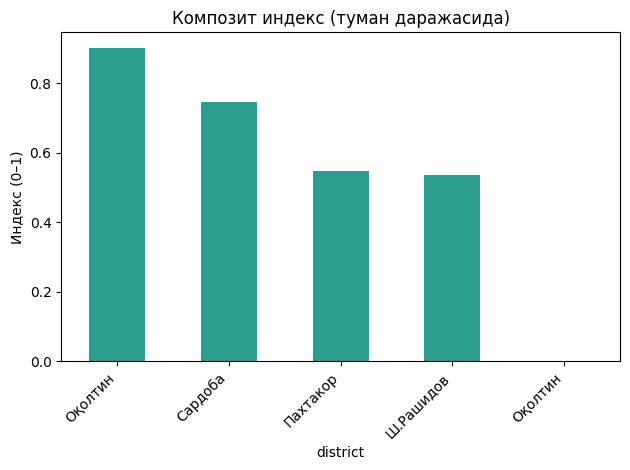

In [200]:
# --- 6️⃣ Бар диаграмма: Композит индекс ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
df_index.sort_values('composite_index', ascending=False).plot(
    x='district', y='composite_index', kind='bar', legend=False, color='#2A9D8F'
)
plt.title("Композит индекс (туман даражасида)")
plt.ylabel("Индекс (0–1)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


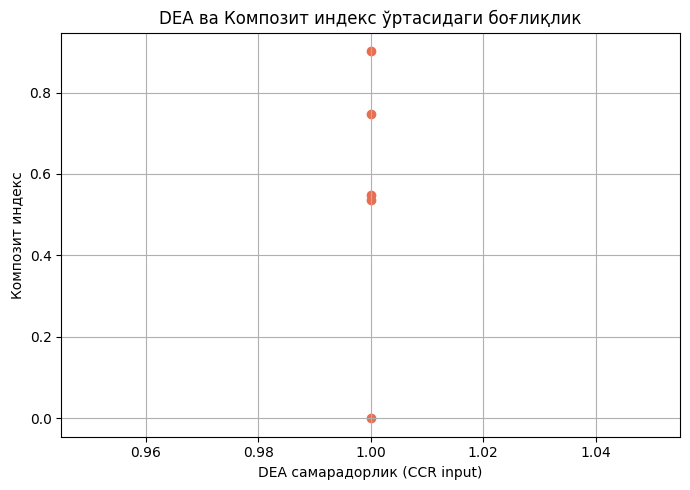

In [201]:
# --- 7️⃣ Scatter plot: DEA самарадорлик ва композит индекс ---
plt.figure(figsize=(7,5))
plt.scatter(df_index['efficiency'], df_index['composite_index'], color='#E76F51')
plt.xlabel("DEA самарадорлик (CCR input)")
plt.ylabel("Композит индекс")
plt.title("DEA ва Композит индекс ўртасидаги боғлиқлик")
plt.grid(True)
plt.tight_layout()
plt.show()

In [202]:
# 4-қадам: Автоматик маълумотнома
import numpy as np

# Туман даражасидаги натижалардан фойдаланамиз
report = agg_d.copy()

# DEA натижаси бўйича таҳлил
avg_eff = report['eff_ccr_input'].mean()
max_eff = report['eff_ccr_input'].max()
min_eff = report['eff_ccr_input'].min()

text = []
text.append("📊 **DEA таҳлили бўйича туманлар кесимида самарадорлик таҳлили**\n")
text.append(f"- Ўртача самарадорлик θ = {avg_eff:.3f}")
text.append(f"- Энг юқори самарадорлик: {max_eff:.3f}")
text.append(f"- Энг паст самарадорлик: {min_eff:.3f}\n")

# Самарадорликка кўра гуруҳлаш
efficient = report[report['eff_ccr_input'] >= 0.9]
moderate = report[(report['eff_ccr_input'] < 0.9) & (report['eff_ccr_input'] >= 0.6)]
low = report[report['eff_ccr_input'] < 0.6]

text.append(f"✅ Самарали туманлар (θ ≥ 0.9): {', '.join(efficient['district']) if len(efficient)>0 else 'йўқ'}")
text.append(f"⚙️ Ўртача самарадор туманлар (0.6 ≤ θ < 0.9): {', '.join(moderate['district']) if len(moderate)>0 else 'йўқ'}")
text.append(f"⚠️ Паст самарадор туманлар (θ < 0.6): {', '.join(low['district']) if len(low)>0 else 'йўқ'}\n")

# Вилоят даражаси бўйича хулоса
text.append("🏙 **Вилоятлар кесимида:**")
for _, row in agg_r.iterrows():
    text.append(f"  - {row['region']}: θ_CCR = {row['eff_ccr_input']:.3f}, θ_BCC = {row['eff_bcc_input']:.3f}")

# Потенциал таҳлил
if min_eff >= 0.9:
    comment = (
        "\n🟢 Барча туманлар DEA бўйича 100% ёки яқин самарадор деб баҳоланган. "
        "Бу кредит маблағларидан умумий ҳолда унумли фойдаланиш кўрсаткичи юқори эканлигини англатади. "
        "Бироқ фирма даражасида самарадорлик фарқи борлиги эҳтимол — айрим кичик субъектлар ресурсдан фойдаланишда қийинчиликка дуч келган бўлиши мумкин."
    )
elif min_eff < 0.6:
    comment = (
        "\n🟠 Айрим туманларда самарадорлик паст. Бу ё кредит миқдорининг нотенг тақсимланиши, "
        "ёки натижа кўрсаткичларининг (иш ўрни, даромад, маҳсулот янгиланиши) пастлиги билан изоҳланиши мумкин. "
        "Бу ҳолда илғор туманлар тажрибасини паст кўрсаткичли ҳудудларга татбиқ этиш мақсадга мувофиқ."
    )
else:
    comment = (
        "\n🟡 Самарадорлик ўрта даражада. Яхшиланиш учун кредит фаолияти ва натижа кўрсаткичларини (даромад, янги маҳсулот, бозор диверсификацияси) кучайтириш керак."
    )

text.append(comment)

# Барча маълумотни чоп этиш
print("\n".join(text))


📊 **DEA таҳлили бўйича туманлар кесимида самарадорлик таҳлили**

- Ўртача самарадорлик θ = 1.000
- Энг юқори самарадорлик: 1.000
- Энг паст самарадорлик: 1.000

✅ Самарали туманлар (θ ≥ 0.9): Оқолтин, Пахтакор, Ш.Рашидов, Оқолтин, Сардоба
⚙️ Ўртача самарадор туманлар (0.6 ≤ θ < 0.9): йўқ
⚠️ Паст самарадор туманлар (θ < 0.6): йўқ

🏙 **Вилоятлар кесимида:**
  - Noma’lum: θ_CCR = 1.000, θ_BCC = 1.000
  - Жиззах вилояти: θ_CCR = 1.000, θ_BCC = 1.000
  - Сирдарё вилояти: θ_CCR = 1.000, θ_BCC = 1.000

🟢 Барча туманлар DEA бўйича 100% ёки яқин самарадор деб баҳоланган. Бу кредит маблағларидан умумий ҳолда унумли фойдаланиш кўрсаткичи юқори эканлигини англатади. Бироқ фирма даражасида самарадорлик фарқи борлиги эҳтимол — айрим кичик субъектлар ресурсдан фойдаланишда қийинчиликка дуч келган бўлиши мумкин.


In [203]:
# --- Фирма даражасида таҳлил ---
firm_df = data.copy()

# Фирмаларни гуруҳлаш
efficient_firms = firm_df[firm_df['eff_ccr_input'] >= 0.9]
moderate_firms = firm_df[(firm_df['eff_ccr_input'] < 0.9) & (firm_df['eff_ccr_input'] >= 0.6)]
low_firms = firm_df[firm_df['eff_ccr_input'] < 0.6]

total_firms = len(firm_df)
share_eff = len(efficient_firms) / total_firms * 100
share_mod = len(moderate_firms) / total_firms * 100
share_low = len(low_firms) / total_firms * 100

print("📊 **Фирма даражасида DEA таҳлили (CCR input-oriented)**")
print(f"- Жами фирмалар: {total_firms}")
print(f"- Самарали (θ ≥ 0.9): {len(efficient_firms)} та ({share_eff:.1f}%)")
print(f"- Ўртача самарадор (0.6 ≤ θ < 0.9): {len(moderate_firms)} та ({share_mod:.1f}%)")
print(f"- Паст самарадор (θ < 0.6): {len(low_firms)} та ({share_low:.1f}%)\n")

# Туманлар кесимида самарадорлик улуши
district_eff = (
    firm_df.groupby('district')['eff_ccr_input']
    .apply(lambda x: (x >= 0.9).sum() / len(x))
    .reset_index(name='efficient_share')
)
district_eff = district_eff.sort_values('efficient_share', ascending=False)
print("📍 Самарадор фирмалар улуши (туман кесимида):")
print(district_eff)

# --- Энг самарасиз 10 та фирма ---
print("\n⚠️ Энг паст самарадор 10 та фирма:")
print(firm_df.sort_values('eff_ccr_input').head(10)[
    ['region','district','credit','eff_ccr_input','annual_revenue','new_jobs_binary','prod_change']
])

# --- Автоматик хулоса ---
comment = []
comment.append("\n🧠 **Хулоса (фирма даражасида):**")

if share_low > 30:
    comment.append("Паст самарадор фирмалар улуши 30%дан юқори — бу кредит маблағларини натижага айлантиришда қийинчиликлар мавжудлигини кўрсатади.")
elif share_mod > 30:
    comment.append("Фирмаларнинг катта қисми (60–90% θ оралиғида) — натижаларни яхшилаш учун имконият бор.")
else:
    comment.append("Кўпчилик фирмалар юқори самарадор — бу тизимли кредит фойдаланиш самарадорлигини кўрсатади.")

comment.append("Самарасиз фирмалар асосан кичик кредит миқдори ёки паст ишлаб чиқариш ўзгаришига эга бўлган субъектлар бўлиши мумкин.")
comment.append("Туман кесимида самарадорлик фарқи етарли — Сардоба ва Пахтакорда индивидуал фирма самарадорлигини қайта кўриб чиқиш тавсия этилади.")

print("\n".join(comment))


📊 **Фирма даражасида DEA таҳлили (CCR input-oriented)**
- Жами фирмалар: 139
- Самарали (θ ≥ 0.9): 35 та (25.2%)
- Ўртача самарадор (0.6 ≤ θ < 0.9): 4 та (2.9%)
- Паст самарадор (θ < 0.6): 100 та (71.9%)

📍 Самарадор фирмалар улуши (туман кесимида):
    district  efficient_share
2    Сардоба         0.375000
0    Оқолтин         0.304348
3  Ш.Рашидов         0.161290
1   Пахтакор         0.133333

⚠️ Энг паст самарадор 10 та фирма:
              region   district  credit  eff_ccr_input  annual_revenue  \
42   Сирдарё вилояти    Сардоба     300       0.033333             9.0   
3    Сирдарё вилояти    Сардоба     300       0.083333            22.5   
61   Сирдарё вилояти    Оқолтин     100       0.100000             9.0   
56   Сирдарё вилояти    Оқолтин     100       0.100000             9.0   
54   Сирдарё вилояти    Оқолтин     100       0.100000             9.0   
107   Жиззах вилояти  Ш.Рашидов     100       0.100000             9.0   
105   Жиззах вилояти  Ш.Рашидов     100       

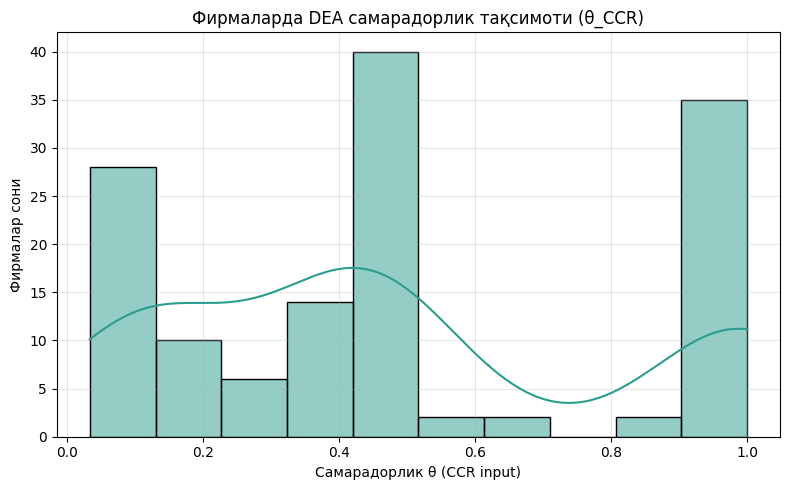

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Самарадорлик тақсимоти (гистограмма) ---
plt.figure(figsize=(8,5))
sns.histplot(data['eff_ccr_input'], bins=10, kde=True, color="#2A9D8F")
plt.title("Фирмаларда DEA самарадорлик тақсимоти (θ_CCR)")
plt.xlabel("Самарадорлик θ (CCR input)")
plt.ylabel("Фирмалар сони")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

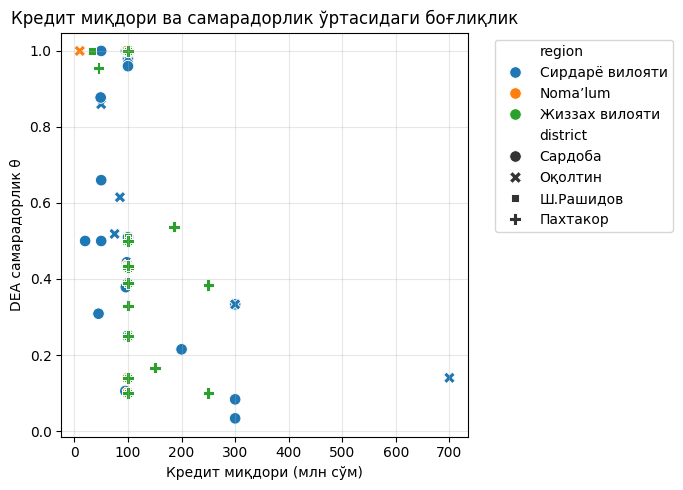

In [209]:
# --- 2️⃣ Кредит миқдори ва самарадорлик ---
plt.figure(figsize=(7,5))
sns.scatterplot(x='credit', y='eff_ccr_input', data=data, hue='region', style='district', s=70)
plt.title("Кредит миқдори ва самарадорлик ўртасидаги боғлиқлик")
plt.xlabel("Кредит миқдори (млн сўм)")
plt.ylabel("DEA самарадорлик θ")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipython-input-198817341.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




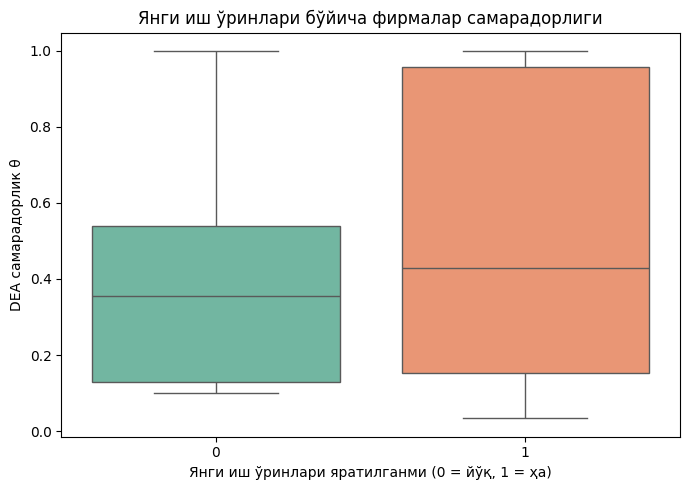

In [206]:
# --- 3️⃣ Янги иш ўринлари ва самарадорлик ---
if 'new_jobs_binary' in data.columns:
    plt.figure(figsize=(7,5))
    sns.boxplot(x='new_jobs_binary', y='eff_ccr_input', data=data, palette="Set2")
    plt.title("Янги иш ўринлари бўйича фирмалар самарадорлиги")
    plt.xlabel("Янги иш ўринлари яратилганми (0 = йўқ, 1 = ҳа)")
    plt.ylabel("DEA самарадорлик θ")
    plt.tight_layout()
    plt.show()

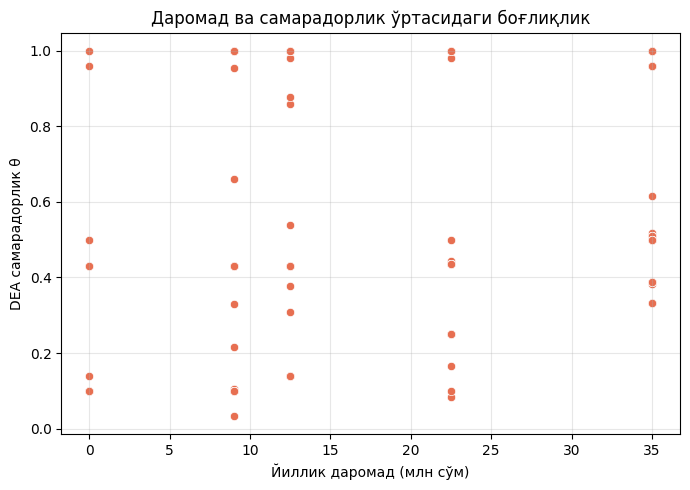

In [207]:
# --- 4️⃣ Йиллик даромад ва самарадорлик ---
plt.figure(figsize=(7,5))
sns.scatterplot(x='annual_revenue', y='eff_ccr_input', data=data, color="#E76F51")
plt.title("Даромад ва самарадорлик ўртасидаги боғлиқлик")
plt.xlabel("Йиллик даромад (млн сўм)")
plt.ylabel("DEA самарадорлик θ")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-878585842.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




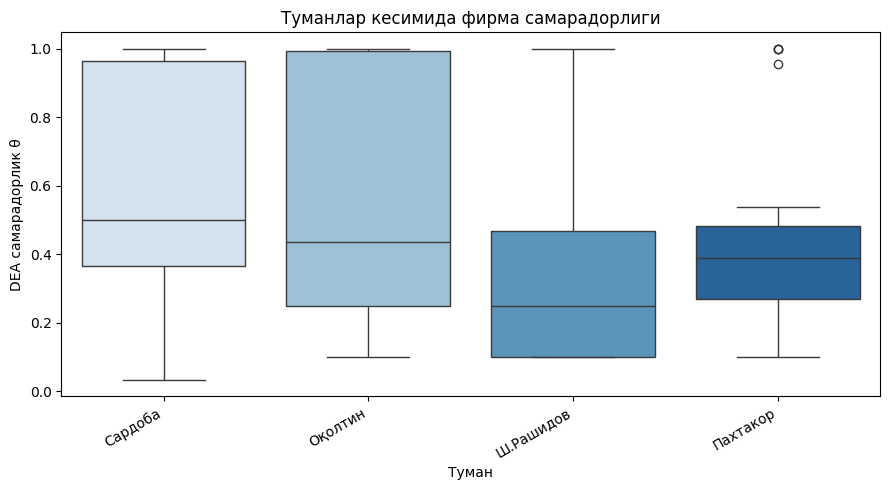

In [208]:
# --- 5️⃣ Самарадорликни туман бўйича таққослаш ---
plt.figure(figsize=(9,5))
sns.boxplot(x='district', y='eff_ccr_input', data=data, palette="Blues")
plt.title("Туманлар кесимида фирма самарадорлиги")
plt.xlabel("Туман")
plt.ylabel("DEA самарадорлик θ")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


**# DEA Regression (OLS модели)**

In [210]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# 1️⃣ Faylni yuklash (DEA natijalari allaqachon data ichida bor)
file_path = "brb.xlsx"
df = pd.read_excel(file_path)

# cleaning натижангдан кейин data DataFrame бор деб оламиз
firm_df = data.copy()

# 2️⃣ Regression uchun explanatory variables (mustaqil o‘zgaruvchilar)
# training, interest rate, term, credit problems, credit size

cols_for_reg = [
    'credit',
    '5. Кредит фоизи (%)',
    '6. Кредит муддати (ой):',
    '9. Бизнес кўникмалари бўйича ўқув курсларида қатнашганмисиз?',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Ҳужжат тўплашда муаммо',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Кўриб чиқиш муддати чўзилди',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Коррупция ҳолатлари'
]

# Файлда керакли устунлар бўлса, оламиз
cols_present = [c for c in cols_for_reg if c in firm_df.columns]
reg_df = firm_df[['eff_ccr_input'] + cols_present].copy()

# --- Cleaning: "Ҳа"/"Йўқ" ни 1/0 га айлантириш ---
def yesno(x):
    s = str(x).lower().strip()
    if s in ['ҳа','ха','да','yes','1']: return 1
    if s in ['йўқ','йок','no','нет','0']: return 0
    return 0

for c in cols_present:
    if reg_df[c].dtype == object:
        reg_df[c] = reg_df[c].apply(yesno)

# --- NaN va sonlarni тозалаш ---
for c in cols_present:
    reg_df[c] = pd.to_numeric(reg_df[c], errors='coerce').fillna(0)

# 3️⃣ Regression model
X = reg_df[cols_present]
y = reg_df['eff_ccr_input']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# 4️⃣ Натижа
print(model.summary())

# 5️⃣ Қисқача таҳлил (автоматик)
impacts = model.params.sort_values(ascending=False)
print("\n📊 Омиллар таъсир кучи (β коэффициентлар):")
print(impacts)

print("\n🧠 Хулоса:")
if '9. Бизнес кўникмалари бўйича ўқув курсларида қатнашганмисиз?' in impacts.index:
    beta = impacts['9. Бизнес кўникмалари бўйича ўқув курсларида қатнашганмисиз?']
    if beta > 0:
        print(f"- Ўқув курсларида қатнашиш DEA самарадорликка ижобий таъсир кўрсатган (β = {beta:.3f}).")
    else:
        print(f"- Ўқув курсларида қатнашиш самарадорликка таъсири паст ёки салбий (β = {beta:.3f}).")

if '5. Кредит фоизи (%)' in impacts.index:
    beta = impacts['5. Кредит фоизи (%)']
    if beta < 0:
        print(f"- Кредит фоизи юқори бўлган фирмаларда самарадорлик паст (β = {beta:.3f}).")
    else:
        print(f"- Кредит фоизи самарадорликка катта таъсир кўрсатмаган (β = {beta:.3f}).")


                            OLS Regression Results                            
Dep. Variable:          eff_ccr_input   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     8.302
Date:                Wed, 12 Nov 2025   Prob (F-statistic):            0.00460
Time:                        11:49:24   Log-Likelihood:                -39.535
No. Observations:                 139   AIC:                             83.07
Df Residuals:                     137   BIC:                             88.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6204      0.053     11.726      0.0

In [222]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# 1️⃣ Asliy Excel faylni o‘qiymiz
file_path = "brb.xlsx"
df = pd.read_excel(file_path)

# 2️⃣ DEA natijalari bo‘lgan jadval (data) dan faqat eff_ccr_input ni olamiz
dea_eff = data[['eff_ccr_input']].reset_index(drop=True)

# 3️⃣ df va DEA natijalarini birlashtiramiz (индекс бўйича)
merged = df.copy()
merged['eff_ccr_input'] = dea_eff['eff_ccr_input']

# 4️⃣ Regression uchun kerakli ustunлар
cols_for_reg = [
    'credit',
    '5. Кредит фоизи (%):',
    '6. Кредит муддати (ой):',
    '9. Бизнес кўникмалари бўйича ўқув курсларида қатнашганмисиз?',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Ҳужжат тўплашда муаммо',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Кўриб чиқиш муддати чўзилди',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Коррупция ҳолатлари',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Маълумот етишмади'
]

# 5️⃣ Cleaning: «Ҳа/Йўқ»ни 1/0 га айлантириш
def yesno(x):
    s = str(x).lower().strip()
    if s in ['ҳа','ха','да','yes','1']: return 1
    if s in ['йўқ','йок','no','нет','0']: return 0
    return 0

for c in cols_for_reg:
    if c in merged.columns and merged[c].dtype == object:
        merged[c] = merged[c].apply(yesno)

# 6️⃣ Фоиз ва муддат устунларини тозалаш
for num_col in ['credit','5. Кредит фоизи (%)','6. Кредит муддати (ой):']:
    if num_col in merged.columns:
        merged[num_col] = (
            merged[num_col]
            .astype(str)
            .str.replace('[^0-9.,]', '', regex=True)
            .replace('', np.nan)
            .astype(float)
            .fillna(0)
        )

# 7️⃣ Regression учун dataset тайёрлаймиз
cols_present = [c for c in cols_for_reg if c in merged.columns]
reg_df = merged[['eff_ccr_input'] + cols_present].dropna()

# 8️⃣ Regression
X = reg_df[cols_present]
y = reg_df['eff_ccr_input']
X = sm.add_constant(X)
model_multi = sm.OLS(y, X).fit()

print(model_multi.summary())

# 9️⃣ Автоматик хулоса
print("\n📊 Омиллар таъсири (β ва p-қийматлар):")
for var, beta, p in zip(model_multi.params.index, model_multi.params, model_multi.pvalues):
    if var == 'const': continue
    direction = 'ижобий' if beta > 0 else 'салбий'
    signif = 'муҳим' if p < 0.05 else 'аҳамиятсиз'
    print(f"- {var}: {direction} ({signif}), β={beta:.4f}, p={p:.4f}")


                            OLS Regression Results                            
Dep. Variable:          eff_ccr_input   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     4.159
Date:                Wed, 12 Nov 2025   Prob (F-statistic):           0.000365
Time:                        12:14:11   Log-Likelihood:                -29.676
No. Observations:                 139   AIC:                             75.35
Df Residuals:                     131   BIC:                             98.83
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning:

divide by zero encountered in scalar divide



In [220]:
# 🧾 Ҳозирги merged DataFrame’даги барча устун номларини кўрсатиш
list(merged.columns)
Кредит олишда қандай муаммоларга дуч келдингиз?/Ҳужжат тўплашда муаммо',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Кўриб чиқиш муддати чўзилди',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Коррупция ҳолатлари',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Маълумот етишмади'

['region',
 'district',
 'form',
 'type_activity',
 'credit_year',
 'bank',
 'credit',
 '5. Кредит фоизи (%):',
 '6. Кредит муддати (ой):',
 '7. Кредит йўналиши:',
 'Бошқа',
 'loan_purpose',
 'Бошқа.1',
 '9. Бизнес кўникмалари бўйича ўқув курсларида қатнашганмисиз?',
 '10. Ушбу курслар самарадорлигини қандай баҳолайсиз?',
 '11. Сертификат олиш жараёнини қандай баҳолайсиз?',
 '12. Кредит олишда қандай муаммоларга дуч келдингиз?',
 '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Ҳужжат тўплашда муаммо',
 '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Кўриб чиқиш муддати чўзилди',
 '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Скоринг талаблари мураккаб',
 '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Сертификат жараёни мураккаб',
 '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Маълумот етишмади',
 '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Муддат узоқ',
 '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Коррупция ҳолатлари',
 '12. Кредит олишда

In [223]:
# 🔍 1️⃣ Тозаланган устунларни текшириш
merged[['12. Кредит олишда қандай муаммоларга дуч келдингиз?/Ҳужжат тўплашда муаммо',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Кўриб чиқиш муддати чўзилди',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Коррупция ҳолатлари',
    '12. Кредит олишда қандай муаммоларга дуч келдингиз?/Маълумот етишмади']].head(5)


,12. Кредит олишда қандай муаммоларга дуч келдингиз?/Ҳужжат тўплашда муаммо,12. Кредит олишда қандай муаммоларга дуч келдингиз?/Кўриб чиқиш муддати чўзилди,12. Кредит олишда қандай муаммоларга дуч келдингиз?/Коррупция ҳолатлари,12. Кредит олишда қандай муаммоларга дуч келдингиз?/Маълумот етишмади
0,0,0,0,0
1,1,1,0,0
2,0,0,0,0
3,0,1,0,0
4,0,0,0,0


In [225]:
# export merged df to xlsx
merged.to_excel('merged_df.xlsx', index=False)
